# Federated Learning

Vamos a resolver un problema de clasificación de imágenes con el dataset MNIST usando Aprendizaje Federado. 

## Preparar el dataset

De modo similar a las prácticas anteriores, cargamos el dataset y lo preprocesamos, dividiendo la intensidad de los píxeles entre 255 para que estén en el rango [0,1].

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be in the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

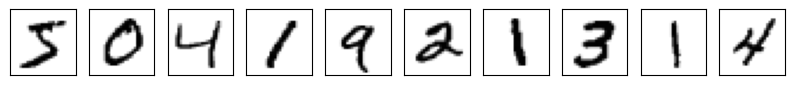

In [3]:
# Draw the first 10 images from the training dataset
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()


## Entorno de aprendizaje federado

Vamos a crear un entorno de aprendizaje federado con 5 clientes.

Para construir la estructura, seguiremos el diagrama de la teoría:

<br>
<img src = "images/fl.png" width = 80%>

In [4]:
# Define the number of federated clients
num_clients = 5

Primero creamos nuestro modelo global, que será distribuido a los distintos agentes.

In [35]:
def create_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])
    return model

In [36]:
global_model = create_model()
global_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

A continuación, inicializamos los agentes, y simulamos que les enviamos el modelo:
1. Utilizamos la función `create_model` para crear un modelo local para cada agente.
2. Tomamos los pesos del modelo global y los asignamos a cada agente, de modo que todos los agentes tengan el mismo modelo inicial.

In [37]:
# Create a list of client models
client_models = []
client_optimizers = []
for i in range(num_clients):
    client_models.append(create_model())
    client_optimizers.append(tf.keras.optimizers.SGD(learning_rate=0.01))

# Clone the global model to initialize the local models
for model in client_models:
    model.set_weights(global_model.get_weights())

Definimos una funció para hacer una ronda de entrenamiento en un cliente dado.

In [38]:
def train_client(client_model, client_optimizer, x, y):
    with tf.GradientTape() as tape:
        logits = client_model(x)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y, logits)
        accuracy = tf.keras.metrics.SparseCategoricalAccuracy()(y, logits)
    grads = tape.gradient(loss, client_model.trainable_weights)
    client_optimizer.apply_gradients(zip(grads, client_model.trainable_weights))
    return loss, accuracy


Y ya podemos simular el entrenamiento federado. Realizaremos 100 rondas de entrenamiento (cada ronda equivale a un epoch). En cada una de ellas:
1. El modelo global se envía a cada agente.
2. Cada agente entrena su modelo local con sus datos.
3. El modelo local de cada agente se envía al servidor.
4. El servidor promedia los modelos recibidos y actualiza el modelo global.

In [31]:
num_rounds = 5
size_batch_train = len(x_train) // num_clients
print(f"Training {num_clients} clients for {num_rounds} rounds, with {size_batch_train} samples in each local batch.\n")

accuracy_history = {'global_model': [], 'client_0': [], 'client_1': [], 'client_2': [], 'client_3': [], 'client_4': []}

loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
print(f"Global model: Loss = {loss}, Accuracy = {round(100 * accuracy, 2)}%\n")

for round_num in range(num_rounds):
    print(f"Round {round_num + 1}")

    # Update the global model with aggregated weights
    global_weights = global_model.get_weights()
    for model in client_models:
        for i, w in enumerate(model.trainable_weights):
            w.assign(global_weights[i])

    # Perform local training on selected clients
    for client_id in range(num_clients):
        x_batch = x_train[client_id * size_batch_train:(client_id + 1) * size_batch_train]
        y_batch = y_train[client_id * size_batch_train:(client_id + 1) * size_batch_train]
        loss, accuracy = train_client(client_models[client_id], client_optimizers[client_id], x_batch, y_batch)
        print(f"  Client {client_id}: Loss = {loss.numpy()}, Accuracy = {round(100 * accuracy.numpy(), 2)}%")
        accuracy_history[f'client_{client_id}'].append(accuracy)

    # Each model sends its local weights to the server
    client_weights = []
    for model in client_models:
        client_weights.append(model.get_weights())

    # Aggregate the model weights manually
    global_weights_new = [tf.zeros_like(w) for w in global_model.trainable_weights]
    for client_id in range(len(client_weights)):
        for i, w in enumerate(client_weights[client_id]):
            global_weights_new[i] += w / len(range(num_clients))
    global_model.set_weights(global_weights_new)

    # Evaluate the global model and print metrics
    loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
    accuracy_history['global_model'].append(accuracy)
    print(f"  Global model: Loss = {loss}, Accuracy = {round(100 * accuracy, 2)}%\n")


    


Training 5 clients for 5 rounds, with 12000 samples in each local batch.

Global model: Loss = 0.8541017770767212, Accuracy = 82.41%

Round 1
  Client 0: Loss = 0.8562303185462952, Accuracy = 82.63%
  Client 1: Loss = 0.8912306427955627, Accuracy = 81.28%
  Client 2: Loss = 0.9010084867477417, Accuracy = 81.08%
  Client 3: Loss = 0.8909053802490234, Accuracy = 81.33%
  Client 4: Loss = 0.8488816022872925, Accuracy = 83.36%
  Global model: Loss = 0.8521400094032288, Accuracy = 82.44%

Round 2
  Client 0: Loss = 0.8543092608451843, Accuracy = 82.66%
  Client 1: Loss = 0.8892905116081238, Accuracy = 81.31%
  Client 2: Loss = 0.8990549445152283, Accuracy = 81.08%
  Client 3: Loss = 0.888968288898468, Accuracy = 81.38%
  Client 4: Loss = 0.8468935489654541, Accuracy = 83.39%
  Global model: Loss = 0.8501903414726257, Accuracy = 82.46%

Round 3
  Client 0: Loss = 0.8524000644683838, Accuracy = 82.68%
  Client 1: Loss = 0.8873623609542847, Accuracy = 81.35%
  Client 2: Loss = 0.89711344242095

In [39]:
num_rounds = 100
size_batch_train = len(x_train) // num_clients
print(f"Training {num_clients} clients for {num_rounds} rounds, with {size_batch_train} samples in each local batch.\n")

accuracy_history = {'global_model': [], 'client_0': [], 'client_1': [], 'client_2': [], 'client_3': [], 'client_4': []}

loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
print(f"Global model: Initial Loss = {loss}, Initial Accuracy = {round(100 * accuracy, 2)}%\n")

for round_num in range(num_rounds):

    # Update the global model with aggregated weights
    global_weights = global_model.get_weights()
    for model in client_models:
        for i, w in enumerate(model.trainable_weights):
            w.assign(global_weights[i])

    # Perform local training on selected clients
    for client_id in range(num_clients):
        x_batch = x_train[client_id * size_batch_train:(client_id + 1) * size_batch_train]
        y_batch = y_train[client_id * size_batch_train:(client_id + 1) * size_batch_train]
        loss, accuracy = train_client(client_models[client_id], client_optimizers[client_id], x_batch, y_batch)
        accuracy_history[f'client_{client_id}'].append(accuracy)

    # Each model sends its local weights to the server
    client_weights = []
    for model in client_models:
        client_weights.append(model.get_weights())

    # Aggregate the model weights manually
    global_weights_new = [tf.zeros_like(w) for w in global_model.trainable_weights]
    for client_id in range(len(client_weights)):
        for i, w in enumerate(client_weights[client_id]):
            global_weights_new[i] += w / len(range(num_clients))
    global_model.set_weights(global_weights_new)

    # Evaluate the global model and print metrics
    loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
    accuracy_history['global_model'].append(accuracy)

    print(f"Round {round_num + 1}. Accuracy: {round(100 * accuracy, 2)}%", end='\r')

    


Training 5 clients for 100 rounds, with 12000 samples in each local batch.

Global model: Initial Loss = 2.4552180767059326, Initial Accuracy = 7.8%



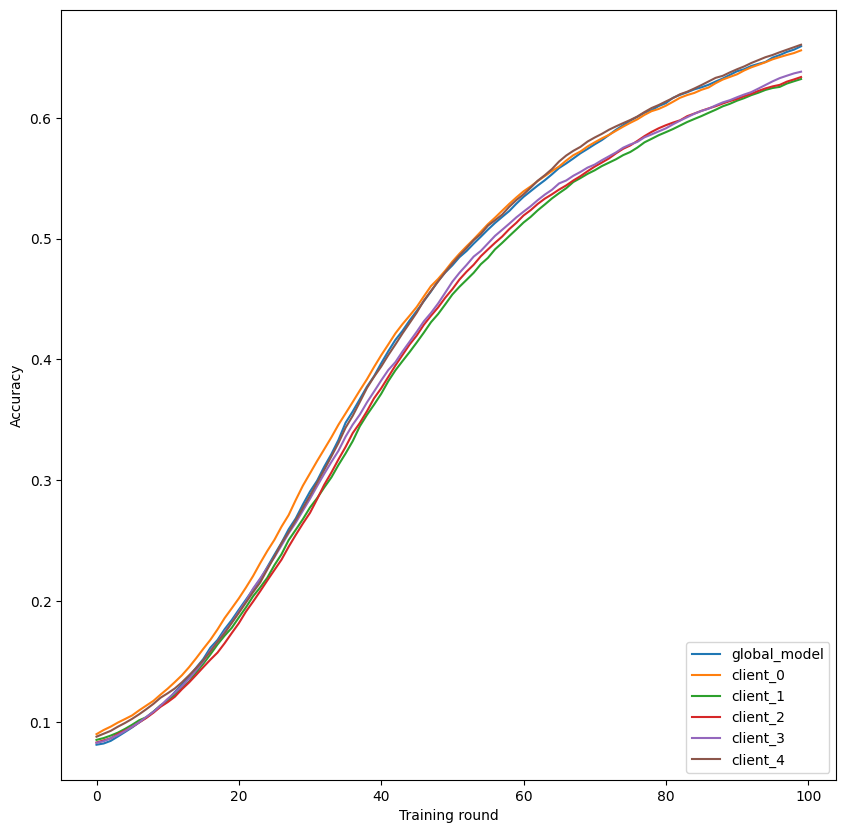

In [43]:
# Draw the accuracy history of the global model and the clients
plt.figure(figsize=(10,10))
plt.plot(accuracy_history['global_model'], label='global_model')
for i in range(num_clients):
    plt.plot(accuracy_history[f'client_{i}'], label=f'client_{i}')
plt.xlabel('Training round')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# Differential Privacy

## 1. Logistics Regresion

Vamos a aplicar Regresión Logística a datos sintéticos para comprobar el impacto de la privacidad diferencial en el modelo.

Comenzamos creando un dataset sintético con 10000 muestras, 2 características y 2 clases.

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from diffprivlib.models import LogisticRegression as DPLogisticRegression

In [64]:
# Generate synthetic data
np.random.seed(42)
X = np.random.rand(10000, 2)
y = (X[:, 0] + X[:, 1] > 1).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

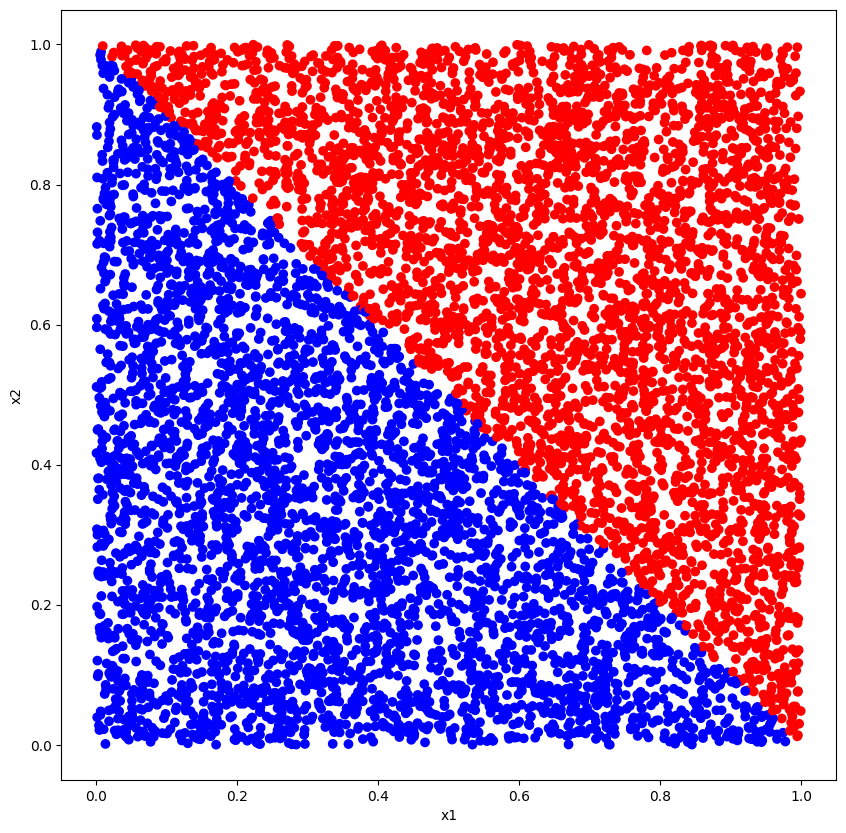

In [69]:
# Plot the training data
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [65]:
# Train a logistic regression model without differential privacy
non_private_model = LogisticRegression()
non_private_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_non_private = non_private_model.predict(X_test)

# Evaluate accuracy
accuracy_non_private = accuracy_score(y_test, y_pred_non_private)
print("Accuracy without differential privacy:", accuracy_non_private)

Accuracy without differential privacy: 0.998


In [66]:
# Train a logistic regression model with differential privacy
dp_model = DPLogisticRegression(epsilon=1.0)  # Set the privacy parameter epsilon
dp_model.fit(X_train, y_train)

# Make predictions on the test set with differential privacy
y_pred_dp = dp_model.predict(X_test)

# Evaluate accuracy
accuracy_dp = accuracy_score(y_test, y_pred_dp)
print("Accuracy with differential privacy:", accuracy_dp)

Accuracy with differential privacy: 0.993


c:\Users\icira\AppData\Local\Programs\Python\Python311\Lib\site-packages\diffprivlib\models\logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


### 2. Neural Network MNIST dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255

In [54]:
# Define the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {accuracy*100:.2f}%")

Epoch 1/5
938/938 [==============================] - 12s 12ms/step - loss: 0.1826 - accuracy: 0.9462
Epoch 2/5
938/938 [==============================] - 12s 12ms/step - loss: 0.0597 - accuracy: 0.9821
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0402 - accuracy: 0.9880
Epoch 4/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0285 - accuracy: 0.9913
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0492 - accuracy: 0.9855
Test accuracy: 98.55%


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer

In [ ]:
# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255

In [68]:
# Define the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Parameters for differential privacy
l2_norm_clip = 1.0
noise_multiplier = 0.1
num_microbatches = 64

# Compile the model with differential privacy optimizer
optimizer = DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.01
)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {accuracy*100:.2f}%")

ModuleNotFoundError: No module named 'tensorflow_privacy'